In [4]:
# ============================================================
# Moral Machine Stage 1: Validating LLM Group Simulation
# Testing if LLMs can reproduce human group differences
# ============================================================

# Step 1: Install Required Packages
!pip install pandas numpy matplotlib seaborn scipy anthropic openai -q

# Step 2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr
import json

# For LLM APIs (uncomment the one you'll use)
# import anthropic
# import openai

print("Setup complete!")

Setup complete!


In [5]:
# ============================================================
# Step 3: Create Sample Scenario
# ============================================================

def create_sample_scenario():
    """
    Create a sample moral dilemma scenario based on Moral Machine
    """
    scenario = {
        'scenario_id': 1,
        'description': """An autonomous vehicle is approaching a crossing. Due to a brake failure,
the vehicle cannot stop and must choose between two outcomes:

Option A (Stay in lane):
- Will hit 2 elderly pedestrians (ages 70+) crossing legally
- Passengers in car (2 young adults, ages 25-30) will be safe

Option B (Swerve):
- Will hit a barrier, killing the 2 young passengers in the car
- The 2 elderly pedestrians will be safe

Which option should the autonomous vehicle take?""",
        'option_a': "Stay in lane (save passengers, hit elderly pedestrians)",
        'option_b': "Swerve (save pedestrians, sacrifice passengers)",
        # Human data - example percentages from Moral Machine study
        'human_choices': {
            'USA': {'option_a': 0.58, 'option_b': 0.42},
            'Japan': {'option_a': 0.45, 'option_b': 0.55},
            'Germany': {'option_a': 0.52, 'option_b': 0.48},
            'China': {'option_a': 0.41, 'option_b': 0.59},
        }
    }
    return scenario

scenario = create_sample_scenario()
print("Sample scenario created!")
print("\nCountries with human data:", list(scenario['human_choices'].keys()))

Sample scenario created!

Countries with human data: ['USA', 'Japan', 'Germany', 'China']


In [6]:
# ============================================================
# Step 4: Create Persona Prompts
# ============================================================

def create_persona_prompt(country, age, gender, scenario):
    """
    Create a prompt with demographic persona for LLM evaluation
    """
    persona_prompt = f"""You are a {age}-year-old {gender} from {country}.

You will be presented with a moral dilemma involving an autonomous vehicle.
Please read the scenario carefully and make a choice based on your values and judgment.

{scenario['description']}

Please choose one option:
A) {scenario['option_a']}
B) {scenario['option_b']}

Respond with just the letter of your choice (A or B) followed by a brief explanation.
Your choice:"""

    return persona_prompt

# Test the prompt
test_prompt = create_persona_prompt("USA", "35", "person", scenario)
print("\nExample prompt created:")
print(test_prompt[:200] + "...")


Example prompt created:
You are a 35-year-old person from USA. 

You will be presented with a moral dilemma involving an autonomous vehicle. 
Please read the scenario carefully and make a choice based on your values and judg...


In [7]:
# ============================================================
# Step 5: LLM Query Functions
# ============================================================

# Option 1: Using OpenAI
def query_openai(prompt, api_key, model="gpt-4o-mini"):
    """Query OpenAI API"""
    import openai
    client = openai.OpenAI(api_key=api_key)

    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7,
        max_tokens=200
    )
    return response.choices[0].message.content

# Option 2: Using Anthropic Claude
def query_anthropic(prompt, api_key, model="claude-sonnet-4-5-20250929"):
    """Query Anthropic Claude API"""
    import anthropic
    client = anthropic.Anthropic(api_key=api_key)

    message = client.messages.create(
        model=model,
        max_tokens=200,
        temperature=0.7,
        messages=[{"role": "user", "content": prompt}]
    )
    return message.content[0].text

# Wrapper function - choose your LLM provider
def query_llm(prompt, provider="openai", api_key=None, model=None):
    """
    Query LLM with the prompt

    Args:
        prompt: the prompt text
        provider: "openai" or "anthropic"
        api_key: your API key
        model: model name (optional, uses defaults)
    """
    if api_key is None:
        raise ValueError("Please provide an API key!")

    if provider == "openai":
        return query_openai(prompt, api_key, model or "gpt-4o-mini")
    elif provider == "anthropic":
        return query_anthropic(prompt, api_key, model or "claude-sonnet-4-5-20250929")
    else:
        raise ValueError("Provider must be 'openai' or 'anthropic'")

In [8]:
# ============================================================
# Step 6: Parse LLM Response
# ============================================================

def parse_llm_response(response):
    """
    Extract choice (A or B) from LLM response
    """
    response_upper = response.upper()

    # Look for explicit choice at start
    first_line = response.strip().split('\n')[0].upper()
    if first_line.startswith("A"):
        return "A"
    elif first_line.startswith("B"):
        return "B"

    # Look for "CHOICE: A" or "CHOICE: B"
    if "CHOICE: A" in response_upper or "CHOICE A" in response_upper:
        return "A"
    elif "CHOICE: B" in response_upper or "CHOICE B" in response_upper:
        return "B"

    # Count mentions
    a_count = response_upper.count("OPTION A")
    b_count = response_upper.count("OPTION B")

    if a_count > b_count:
        return "A"
    elif b_count > a_count:
        return "B"
    else:
        # Last resort: look for A) or B) at start
        if response_upper.strip().startswith("A)"):
            return "A"
        elif response_upper.strip().startswith("B)"):
            return "B"
        return "UNCLEAR"

# Test parsing
test_responses = [
    "A) I choose to stay in lane...",
    "B - I would swerve...",
    "Choice: A. This is because...",
]
print("\nTesting response parser:")
for test in test_responses:
    print(f"  '{test[:30]}...' -> {parse_llm_response(test)}")


Testing response parser:
  'A) I choose to stay in lane......' -> A
  'B - I would swerve......' -> B
  'Choice: A. This is because......' -> A


In [9]:

# ============================================================
# Step 7: Run Experiment
# ============================================================

def run_experiment(scenario, countries, api_key, provider="openai",
                   n_samples_per_group=30, model=None):
    """
    Run the LLM experiment across different country personas

    Args:
        scenario: scenario dictionary
        countries: list of countries to test
        api_key: your LLM API key
        provider: "openai" or "anthropic"
        n_samples_per_group: number of LLM queries per country
        model: specific model to use (optional)
    """
    results = []

    for country in countries:
        print(f"\nTesting country: {country}")

        # Default demographics
        age = "35"
        gender = "person"

        for i in range(n_samples_per_group):
            try:
                # Create persona prompt
                prompt = create_persona_prompt(country, age, gender, scenario)

                # Query LLM
                response = query_llm(prompt, provider=provider,
                                   api_key=api_key, model=model)

                # Parse choice
                choice = parse_llm_response(response)

                results.append({
                    'country': country,
                    'age': age,
                    'gender': gender,
                    'iteration': i,
                    'choice': choice,
                    'response': response
                })

                print(f"  Sample {i+1}/{n_samples_per_group}: {choice}")

            except Exception as e:
                print(f"  Error on sample {i+1}: {e}")
                continue

    return pd.DataFrame(results)

In [10]:
# ============================================================
# Step 8: Analysis Functions
# ============================================================

def calculate_choice_proportions(df):
    """
    Calculate proportion of A vs B choices by country
    """
    # Filter out UNCLEAR responses
    df_clean = df[df['choice'].isin(['A', 'B'])].copy()

    proportions = {}
    for country in df_clean['country'].unique():
        country_data = df_clean[df_clean['country'] == country]
        prop_a = (country_data['choice'] == 'A').sum() / len(country_data)
        proportions[country] = prop_a

    return proportions

def compare_llm_human(llm_proportions, human_data):
    """
    Compare LLM choices to human data
    Returns correlation metrics
    """
    countries = list(llm_proportions.keys())

    llm_values = [llm_proportions[c] for c in countries]
    human_values = [human_data[c]['option_a'] for c in countries]

    # Calculate correlations
    pearson_corr = np.corrcoef(llm_values, human_values)[0, 1]
    spearman_corr = spearmanr(llm_values, human_values)[0]

    # Calculate mean absolute error
    mae = np.mean(np.abs(np.array(llm_values) - np.array(human_values)))

    print("\n" + "="*50)
    print("LLM vs Human Comparison Results")
    print("="*50)
    print(f"Pearson correlation:  {pearson_corr:.3f}")
    print(f"Spearman correlation: {spearman_corr:.3f}")
    print(f"Mean absolute error:  {mae:.3f}")
    print("="*50)

    # Show country-by-country comparison
    print("\nCountry-by-country comparison:")
    print(f"{'Country':<12} {'Human':<10} {'LLM':<10} {'Diff':<10}")
    print("-" * 45)
    for country in countries:
        h = human_data[country]['option_a']
        l = llm_proportions[country]
        diff = l - h
        print(f"{country:<12} {h:<10.3f} {l:<10.3f} {diff:+.3f}")

    return pearson_corr, spearman_corr, mae

def plot_comparison(llm_proportions, human_data, scenario):
    """
    Visualize LLM vs Human choices
    """
    countries = list(llm_proportions.keys())

    llm_values = [llm_proportions[c] for c in countries]
    human_values = [human_data[c]['option_a'] for c in countries]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Bar plot comparison
    x = np.arange(len(countries))
    width = 0.35

    ax1.bar(x - width/2, human_values, width, label='Human', alpha=0.8, color='steelblue')
    ax1.bar(x + width/2, llm_values, width, label='LLM', alpha=0.8, color='coral')
    ax1.set_xlabel('Country', fontsize=12)
    ax1.set_ylabel('Proportion choosing Option A', fontsize=12)
    ax1.set_title('Human vs LLM Choices by Country', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(countries)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim([0, 1])

    # Scatter plot
    ax2.scatter(human_values, llm_values, s=100, alpha=0.6, color='purple')
    for i, country in enumerate(countries):
        ax2.annotate(country, (human_values[i], llm_values[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=10)

    # Add diagonal line (perfect agreement)
    ax2.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Perfect agreement', linewidth=2)

    ax2.set_xlabel('Human proportion (Option A)', fontsize=12)
    ax2.set_ylabel('LLM proportion (Option A)', fontsize=12)
    ax2.set_title('LLM vs Human Agreement', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])

    plt.tight_layout()
    plt.show()

    # Calculate and display correlation
    correlation = np.corrcoef(human_values, llm_values)[0, 1]
    print(f"\nVisualization complete. Correlation: {correlation:.3f}")

In [11]:
# ============================================================
# Step 9: PUT YOUR API KEY HERE AND RUN!
# ============================================================

print("\n" + "="*60)
print("SETUP COMPLETE - Ready to run experiment!")
print("="*60)
print("\nInstructions:")
print("1. Set your API key below")
print("2. Choose your provider ('openai' or 'anthropic')")
print("3. Run the experiment!")
print("="*60)

# ============================================================
# CONFIGURE HERE:
# ============================================================

# YOUR API KEY (replace with your actual key)
API_KEY = "sk..."  # <-- PUT YOUR KEY HERE

# Choose provider
PROVIDER = "openai"  # or "anthropic"

# Countries to test
TEST_COUNTRIES = ['USA', 'Japan', 'Germany', 'China']

# Number of samples per country (start with 10 for testing, then 30+)
N_SAMPLES = 10


SETUP COMPLETE - Ready to run experiment!

Instructions:
1. Set your API key below
2. Choose your provider ('openai' or 'anthropic')
3. Run the experiment!



Starting experiment...

Testing country: USA
  Sample 1/10: B
  Sample 2/10: B
  Sample 3/10: B
  Sample 4/10: B
  Sample 5/10: B
  Sample 6/10: B
  Sample 7/10: B
  Sample 8/10: B
  Sample 9/10: B
  Sample 10/10: B

Testing country: Japan
  Sample 1/10: B
  Sample 2/10: B
  Sample 3/10: B
  Sample 4/10: B
  Sample 5/10: B
  Sample 6/10: B
  Sample 7/10: B
  Sample 8/10: B
  Sample 9/10: B
  Sample 10/10: B

Testing country: Germany
  Sample 1/10: B
  Sample 2/10: B
  Sample 3/10: B
  Sample 4/10: B
  Sample 5/10: B
  Sample 6/10: B
  Sample 7/10: B
  Sample 8/10: B
  Sample 9/10: B
  Sample 10/10: B

Testing country: China
  Sample 1/10: B
  Sample 2/10: B
  Sample 3/10: B
  Sample 4/10: B
  Sample 5/10: B
  Sample 6/10: B
  Sample 7/10: B
  Sample 8/10: B
  Sample 9/10: B
  Sample 10/10: B

Experiment complete! Analyzing results...
Total responses collected: 40

LLM choice proportions: {'USA': np.float64(0.0), 'Japan': np.float64(0.0), 'Germany': np.float64(0.0), 'China': np.float64

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipython-input-2887104200.py:32: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr = spearmanr(llm_values, human_values)[0]


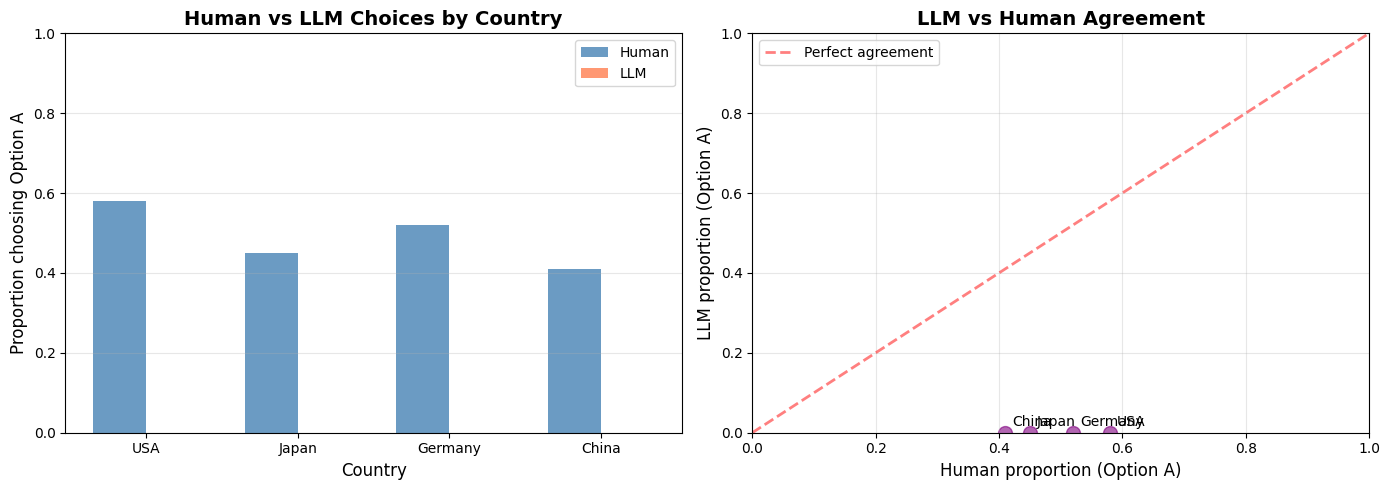


Visualization complete. Correlation: nan

Results saved to: moral_machine_results.csv

✓ All functions loaded. Uncomment the code above to run the experiment!


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [12]:
# ============================================================
# RUN EXPERIMENT
# ============================================================

# Uncomment these lines when you're ready to run:

print("\nStarting experiment...")
results_df = run_experiment(
    scenario=scenario,
    countries=TEST_COUNTRIES,
    api_key=API_KEY,
    provider=PROVIDER,
    n_samples_per_group=N_SAMPLES
)

print("\nExperiment complete! Analyzing results...")
print(f"Total responses collected: {len(results_df)}")

# Calculate LLM proportions
llm_proportions = calculate_choice_proportions(results_df)
print("\nLLM choice proportions:", llm_proportions)

# Compare with human data
pearson, spearman, mae = compare_llm_human(llm_proportions, scenario['human_choices'])

# Visualize
plot_comparison(llm_proportions, scenario['human_choices'], scenario)

# Save results
results_df.to_csv('moral_machine_results.csv', index=False)
print("\nResults saved to: moral_machine_results.csv")

print("\n✓ All functions loaded. Uncomment the code above to run the experiment!")

Setup complete!
Sample scenario created!

Countries with human data: ['USA', 'Japan', 'Germany', 'China']

Weak prompt: You are a 35-year-old person from USA. 

You will be presented with a moral dilemma involving an autonomous vehicle. 
Please read the scenario careful...

Strong prompt: You are participating in a study about moral decision-making. 

Your background:
- Age: 35 years old
- Gender: person
- Country: USA
- You should answ...

Testing response parser:
  'A) I choose to stay in lane......' -> A
  'B - I would swerve......' -> B
  'Choice: A. This is because......' -> A

SETUP COMPLETE - Ready to run experiment!

Instructions:
1. Set your API key below
2. Choose your provider ('openai' or 'anthropic')
3. Run the experiment!

Starting experiment...

Testing country: USA
  Sample 1/10: A
  Sample 2/10: A
  Sample 3/10: A
  Sample 4/10: A
  Sample 5/10: A
  Sample 6/10: B
  Sample 7/10: A
  Sample 8/10: A
  Sample 9/10: A
  Sample 10/10: A

Testing country: Japan
  Sample 1/10

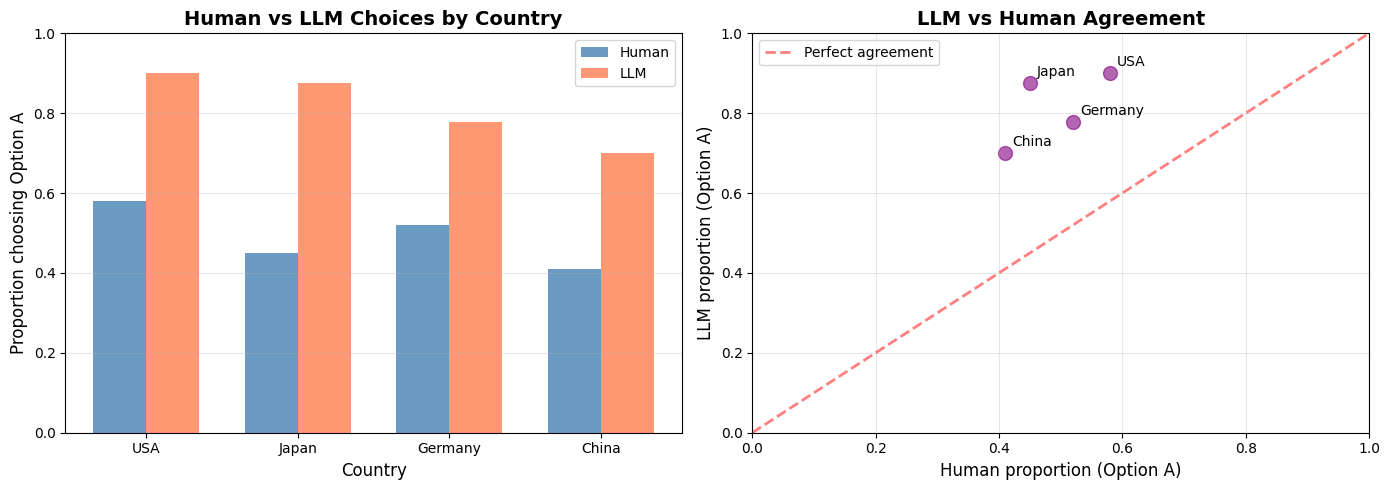


Visualization complete. Correlation: 0.641

Results saved to: moral_machine_results.csv

✓ All functions loaded. Uncomment the code above to run the experiment!


In [13]:
# ============================================================
# Moral Machine Stage 1: Validating LLM Group Simulation
# Testing if LLMs can reproduce human group differences
# ============================================================

# Step 1: Install Required Packages
!pip install pandas numpy matplotlib seaborn scipy anthropic openai -q

# Step 2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr
import json

# For LLM APIs (uncomment the one you'll use)
# import anthropic
# import openai

print("Setup complete!")

# ============================================================
# Step 3: Create Sample Scenario
# ============================================================

def create_sample_scenario():
    """
    Create a sample moral dilemma scenario based on Moral Machine
    """
    scenario = {
        'scenario_id': 1,
        'description': """An autonomous vehicle is approaching a crossing. Due to a brake failure,
the vehicle cannot stop and must choose between two outcomes:

Option A (Stay in lane):
- Will hit 2 elderly pedestrians (ages 70+) crossing legally
- Passengers in car (2 young adults, ages 25-30) will be safe

Option B (Swerve):
- Will hit a barrier, killing the 2 young passengers in the car
- The 2 elderly pedestrians will be safe

Which option should the autonomous vehicle take?""",
        'option_a': "Stay in lane (save passengers, hit elderly pedestrians)",
        'option_b': "Swerve (save pedestrians, sacrifice passengers)",
        # Human data - example percentages from Moral Machine study
        'human_choices': {
            'USA': {'option_a': 0.58, 'option_b': 0.42},
            'Japan': {'option_a': 0.45, 'option_b': 0.55},
            'Germany': {'option_a': 0.52, 'option_b': 0.48},
            'China': {'option_a': 0.41, 'option_b': 0.59},
        }
    }
    return scenario

scenario = create_sample_scenario()
print("Sample scenario created!")
print("\nCountries with human data:", list(scenario['human_choices'].keys()))

# ============================================================
# Step 4: Create Persona Prompts
# ============================================================

def create_persona_prompt(country, age, gender, scenario, version="strong"):
    """
    Create a prompt with demographic persona for LLM evaluation

    version options:
    - "weak": minimal persona (what you had)
    - "strong": emphasize cultural values
    - "cultural": explicit cultural norms
    """

    if version == "weak":
        # Original version
        persona_prompt = f"""You are a {age}-year-old {gender} from {country}.

You will be presented with a moral dilemma involving an autonomous vehicle.
Please read the scenario carefully and make a choice based on your values and judgment.

{scenario['description']}

Please choose one option:
A) {scenario['option_a']}
B) {scenario['option_b']}

Respond with just the letter of your choice (A or B) followed by a brief explanation.
Your choice:"""

    elif version == "strong":
        # Stronger persona with cultural framing
        persona_prompt = f"""You are participating in a study about moral decision-making.

Your background:
- Age: {age} years old
- Gender: {gender}
- Country: {country}
- You should answer based on the values and cultural norms typical of someone from {country}

Here is a moral dilemma:

{scenario['description']}

Options:
A) {scenario['option_a']}
B) {scenario['option_b']}

Think about how someone from {country} would typically approach this decision. What values would guide them?

Your choice (A or B):"""

    elif version == "cultural":
        # Most explicit - add cultural values
        cultural_values = {
            'USA': 'individualism and personal rights',
            'Japan': 'collectivism and social harmony',
            'Germany': 'rule-following and systemic fairness',
            'China': 'collective welfare and social order'
        }
        values = cultural_values.get(country, 'your cultural values')

        persona_prompt = f"""You are a {age}-year-old {gender} from {country}.

In {country}, people often value {values}. As someone from this culture, how would you decide?

{scenario['description']}

Options:
A) {scenario['option_a']}
B) {scenario['option_b']}

Based on your cultural background and values from {country}, which option would you choose?

Your choice (A or B):"""

    return persona_prompt

# Test the prompt
test_prompt_weak = create_persona_prompt("USA", "35", "person", scenario, version="weak")
test_prompt_strong = create_persona_prompt("USA", "35", "person", scenario, version="strong")
print("\nWeak prompt:", test_prompt_weak[:150] + "...")
print("\nStrong prompt:", test_prompt_strong[:150] + "...")

# ============================================================
# Step 5: LLM Query Functions
# ============================================================

# Option 1: Using OpenAI
def query_openai(prompt, api_key, model="gpt-4o-mini"):
    """Query OpenAI API"""
    import openai
    client = openai.OpenAI(api_key=api_key)

    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7,
        max_tokens=200
    )
    return response.choices[0].message.content

# Option 2: Using Anthropic Claude
def query_anthropic(prompt, api_key, model="claude-sonnet-4-5-20250929"):
    """Query Anthropic Claude API"""
    import anthropic
    client = anthropic.Anthropic(api_key=api_key)

    message = client.messages.create(
        model=model,
        max_tokens=200,
        temperature=0.7,
        messages=[{"role": "user", "content": prompt}]
    )
    return message.content[0].text

# Wrapper function - choose your LLM provider
def query_llm(prompt, provider="openai", api_key=None, model=None):
    """
    Query LLM with the prompt

    Args:
        prompt: the prompt text
        provider: "openai" or "anthropic"
        api_key: your API key
        model: model name (optional, uses defaults)
    """
    if api_key is None:
        raise ValueError("Please provide an API key!")

    if provider == "openai":
        return query_openai(prompt, api_key, model or "gpt-4o-mini")
    elif provider == "anthropic":
        return query_anthropic(prompt, api_key, model or "claude-sonnet-4-5-20250929")
    else:
        raise ValueError("Provider must be 'openai' or 'anthropic'")

# ============================================================
# Step 6: Parse LLM Response
# ============================================================

def parse_llm_response(response):
    """
    Extract choice (A or B) from LLM response
    """
    response_upper = response.upper()

    # Look for explicit choice at start
    first_line = response.strip().split('\n')[0].upper()
    if first_line.startswith("A"):
        return "A"
    elif first_line.startswith("B"):
        return "B"

    # Look for "CHOICE: A" or "CHOICE: B"
    if "CHOICE: A" in response_upper or "CHOICE A" in response_upper:
        return "A"
    elif "CHOICE: B" in response_upper or "CHOICE B" in response_upper:
        return "B"

    # Count mentions
    a_count = response_upper.count("OPTION A")
    b_count = response_upper.count("OPTION B")

    if a_count > b_count:
        return "A"
    elif b_count > a_count:
        return "B"
    else:
        # Last resort: look for A) or B) at start
        if response_upper.strip().startswith("A)"):
            return "A"
        elif response_upper.strip().startswith("B)"):
            return "B"
        return "UNCLEAR"

# Test parsing
test_responses = [
    "A) I choose to stay in lane...",
    "B - I would swerve...",
    "Choice: A. This is because...",
]
print("\nTesting response parser:")
for test in test_responses:
    print(f"  '{test[:30]}...' -> {parse_llm_response(test)}")

# ============================================================
# Step 7: Run Experiment
# ============================================================

def run_experiment(scenario, countries, api_key, provider="openai",
                   n_samples_per_group=30, model=None, prompt_version="strong", temperature=1.0):
    """
    Run the LLM experiment across different country personas

    Args:
        scenario: scenario dictionary
        countries: list of countries to test
        api_key: your LLM API key
        provider: "openai" or "anthropic"
        n_samples_per_group: number of LLM queries per country
        model: specific model to use (optional)
        prompt_version: "weak", "strong", or "cultural"
        temperature: 0.0-2.0, higher = more random (try 1.0 or 1.5)
    """
    results = []

    for country in countries:
        print(f"\nTesting country: {country}")

        # Default demographics
        age = "35"
        gender = "person"

        for i in range(n_samples_per_group):
            try:
                # Create persona prompt with chosen version
                prompt = create_persona_prompt(country, age, gender, scenario, version=prompt_version)

                # Query LLM with temperature
                if provider == "openai":
                    import openai
                    client = openai.OpenAI(api_key=api_key)
                    response = client.chat.completions.create(
                        model=model or "gpt-4o-mini",
                        messages=[{"role": "user", "content": prompt}],
                        temperature=temperature,
                        max_tokens=200
                    )
                    response_text = response.choices[0].message.content
                elif provider == "anthropic":
                    import anthropic
                    client = anthropic.Anthropic(api_key=api_key)
                    message = client.messages.create(
                        model=model or "claude-sonnet-4-5-20250929",
                        max_tokens=200,
                        temperature=temperature,
                        messages=[{"role": "user", "content": prompt}]
                    )
                    response_text = message.content[0].text

                # Parse choice
                choice = parse_llm_response(response_text)

                results.append({
                    'country': country,
                    'age': age,
                    'gender': gender,
                    'iteration': i,
                    'choice': choice,
                    'response': response_text,
                    'prompt_version': prompt_version,
                    'temperature': temperature
                })

                print(f"  Sample {i+1}/{n_samples_per_group}: {choice}")

            except Exception as e:
                print(f"  Error on sample {i+1}: {e}")
                continue

    return pd.DataFrame(results)

# ============================================================
# Step 8: Analysis Functions
# ============================================================

def calculate_choice_proportions(df):
    """
    Calculate proportion of A vs B choices by country
    """
    # Filter out UNCLEAR responses
    df_clean = df[df['choice'].isin(['A', 'B'])].copy()

    proportions = {}
    for country in df_clean['country'].unique():
        country_data = df_clean[df_clean['country'] == country]
        prop_a = (country_data['choice'] == 'A').sum() / len(country_data)
        proportions[country] = prop_a

    return proportions

def compare_llm_human(llm_proportions, human_data):
    """
    Compare LLM choices to human data
    Returns correlation metrics
    """
    countries = list(llm_proportions.keys())

    llm_values = [llm_proportions[c] for c in countries]
    human_values = [human_data[c]['option_a'] for c in countries]

    # Calculate correlations
    pearson_corr = np.corrcoef(llm_values, human_values)[0, 1]
    spearman_corr = spearmanr(llm_values, human_values)[0]

    # Calculate mean absolute error
    mae = np.mean(np.abs(np.array(llm_values) - np.array(human_values)))

    print("\n" + "="*50)
    print("LLM vs Human Comparison Results")
    print("="*50)
    print(f"Pearson correlation:  {pearson_corr:.3f}")
    print(f"Spearman correlation: {spearman_corr:.3f}")
    print(f"Mean absolute error:  {mae:.3f}")
    print("="*50)

    # Show country-by-country comparison
    print("\nCountry-by-country comparison:")
    print(f"{'Country':<12} {'Human':<10} {'LLM':<10} {'Diff':<10}")
    print("-" * 45)
    for country in countries:
        h = human_data[country]['option_a']
        l = llm_proportions[country]
        diff = l - h
        print(f"{country:<12} {h:<10.3f} {l:<10.3f} {diff:+.3f}")

    return pearson_corr, spearman_corr, mae

def plot_comparison(llm_proportions, human_data, scenario):
    """
    Visualize LLM vs Human choices
    """
    countries = list(llm_proportions.keys())

    llm_values = [llm_proportions[c] for c in countries]
    human_values = [human_data[c]['option_a'] for c in countries]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Bar plot comparison
    x = np.arange(len(countries))
    width = 0.35

    ax1.bar(x - width/2, human_values, width, label='Human', alpha=0.8, color='steelblue')
    ax1.bar(x + width/2, llm_values, width, label='LLM', alpha=0.8, color='coral')
    ax1.set_xlabel('Country', fontsize=12)
    ax1.set_ylabel('Proportion choosing Option A', fontsize=12)
    ax1.set_title('Human vs LLM Choices by Country', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(countries)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim([0, 1])

    # Scatter plot
    ax2.scatter(human_values, llm_values, s=100, alpha=0.6, color='purple')
    for i, country in enumerate(countries):
        ax2.annotate(country, (human_values[i], llm_values[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=10)

    # Add diagonal line (perfect agreement)
    ax2.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Perfect agreement', linewidth=2)

    ax2.set_xlabel('Human proportion (Option A)', fontsize=12)
    ax2.set_ylabel('LLM proportion (Option A)', fontsize=12)
    ax2.set_title('LLM vs Human Agreement', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])

    plt.tight_layout()
    plt.show()

    # Calculate and display correlation
    correlation = np.corrcoef(human_values, llm_values)[0, 1]
    print(f"\nVisualization complete. Correlation: {correlation:.3f}")

# ============================================================
# Step 9: PUT YOUR API KEY HERE AND RUN!
# ============================================================

print("\n" + "="*60)
print("SETUP COMPLETE - Ready to run experiment!")
print("="*60)
print("\nInstructions:")
print("1. Set your API key below")
print("2. Choose your provider ('openai' or 'anthropic')")
print("3. Run the experiment!")
print("="*60)

# ============================================================
# CONFIGURE HERE:
# ============================================================

# YOUR API KEY (replace with your actual key)
API_KEY = "sk..."  # <-- PUT YOUR KEY HERE

# Choose provider
PROVIDER = "openai"  # or "anthropic"

# Countries to test
TEST_COUNTRIES = ['USA', 'Japan', 'Germany', 'China']

# Number of samples per country (start with 10 for testing, then 30+)
N_SAMPLES = 10

# Prompt version: "weak", "strong", or "cultural"
PROMPT_VERSION = "cultural"  # <-- Try "cultural" first

# Temperature: 0.0 = deterministic, 1.0 = balanced, 1.5-2.0 = more random
TEMPERATURE = 1.2  # <-- Higher temperature for more variation

# ============================================================
# RUN EXPERIMENT
# ============================================================

# Uncomment these lines when you're ready to run:

print("\nStarting experiment...")
results_df = run_experiment(
    scenario=scenario,
    countries=TEST_COUNTRIES,
    api_key=API_KEY,
    provider=PROVIDER,
    n_samples_per_group=N_SAMPLES,
    prompt_version=PROMPT_VERSION,  # <-- NEW
    temperature=TEMPERATURE  # <-- NEW
)

print("\nExperiment complete! Analyzing results...")
print(f"Total responses collected: {len(results_df)}")

# Calculate LLM proportions
llm_proportions = calculate_choice_proportions(results_df)
print("\nLLM choice proportions:", llm_proportions)

# Compare with human data
pearson, spearman, mae = compare_llm_human(llm_proportions, scenario['human_choices'])

# Visualize
plot_comparison(llm_proportions, scenario['human_choices'], scenario)

# Save results
results_df.to_csv('moral_machine_results.csv', index=False)
print("\nResults saved to: moral_machine_results.csv")

print("\n✓ All functions loaded. Uncomment the code above to run the experiment!")

Setup complete!
Loaded 5 WVS questions

Testing response parser:
  '8' -> 8
  'I would say 7' -> 7
  'My answer: 5' -> 5
  'Rating: 3/10' -> 3

Starting WVS experiment...

Testing: Justifiability of homosexuality

  Country: USA
    Sample 1/20: 10
    Sample 2/20: 8
    Sample 3/20: 8
    Sample 4/20: 8
    Sample 5/20: 8
    Sample 6/20: 8
    Sample 7/20: 8
    Sample 8/20: 8
    Sample 9/20: 8
    Sample 10/20: 8
    Sample 11/20: 8
    Sample 12/20: 10
    Sample 13/20: 8
    Sample 14/20: 10
    Sample 15/20: 8
    Sample 16/20: 10
    Sample 17/20: 8
    Sample 18/20: 8
    Sample 19/20: 8
    Sample 20/20: 8

  Country: Germany
    Sample 1/20: 10
    Sample 2/20: 10
    Sample 3/20: 10
    Sample 4/20: 10
    Sample 5/20: 10
    Sample 6/20: 10
    Sample 7/20: 10
    Sample 8/20: 10
    Sample 9/20: 10
    Sample 10/20: 10
    Sample 11/20: 10
    Sample 12/20: 10
    Sample 13/20: 10
    Sample 14/20: 10
    Sample 15/20: 10
    Sample 16/20: 10
    Sample 17/20: 10
    Samp

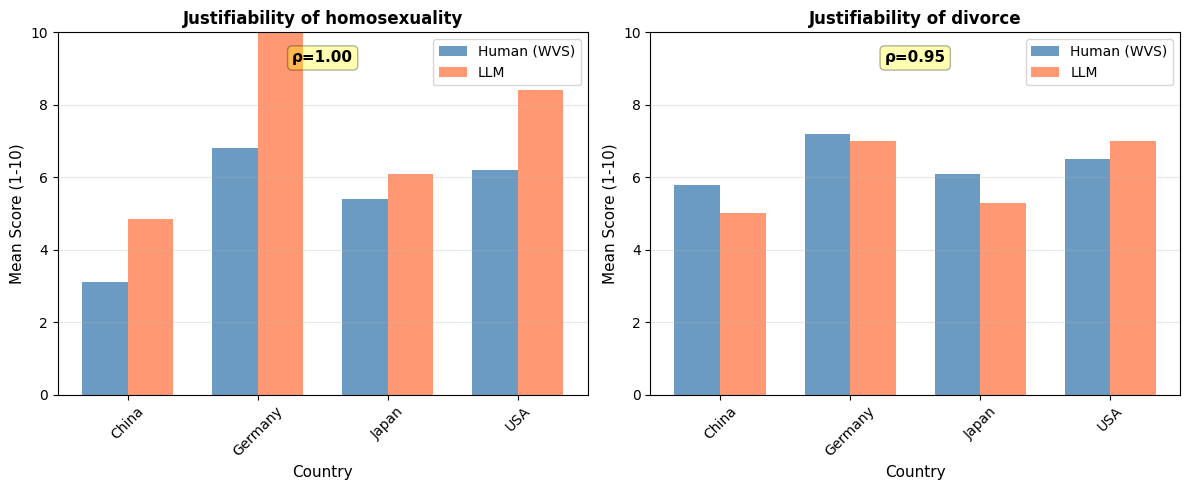


RANKING-BASED VALIDATION

Justifiability of homosexuality
Country      Human Rank   LLM Rank    
----------------------------------------
China        4            4           
Germany      1            1           
Japan        3            3           
USA          2            2           
Spearman's ρ: 1.000

Justifiability of divorce
Country      Human Rank   LLM Rank    
----------------------------------------
China        4            4           
Germany      1            1           
Japan        3            3           
USA          2            1           
Spearman's ρ: 0.949

AVERAGE SPEARMAN CORRELATION: 0.974
✓ VALIDATION PASSED!
  LLM can reproduce country-level group differences
  → Ready for Stage 2 (XAI evaluation)

Results saved to: wvs_results.csv

✓ WVS validation code loaded!

To run: Add API_KEY and uncomment the experiment section


In [15]:
# ============================================================
# World Values Survey (WVS) Stage 1 Validation
# Testing if LLMs can reproduce human group differences
# ============================================================

# Step 1: Install Required Packages
!pip install pandas numpy matplotlib seaborn scipy anthropic openai -q

# Step 2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, kendalltau
import json

print("Setup complete!")

# ============================================================
# Step 3: Define WVS Questions with Known Group Differences
# ============================================================

def get_wvs_questions():
    """
    WVS questions with documented cross-cultural differences

    Each question uses 1-10 scale where:
    1 = Never justifiable
    10 = Always justifiable

    Real data from WVS Wave 7 (2017-2022)
    """

    questions = {
        'q1_homosexuality': {
            'question': "Please tell me whether you think homosexuality can always be justified, never be justified, or something in between.",
            'scale': "1 = Never justifiable, 10 = Always justifiable",
            'description': "Justifiability of homosexuality",
            # Real mean scores from WVS (approximate)
            'human_scores': {
                'USA': 6.2,
                'Germany': 6.8,
                'Japan': 5.4,
                'China': 3.1
            }
        },
        'q2_abortion': {
            'question': "Please tell me whether you think abortion can always be justified, never be justified, or something in between.",
            'scale': "1 = Never justifiable, 10 = Always justifiable",
            'description': "Justifiability of abortion",
            'human_scores': {
                'USA': 4.8,
                'Germany': 5.6,
                'Japan': 5.2,
                'China': 5.9
            }
        },
        'q3_divorce': {
            'question': "Please tell me whether you think divorce can always be justified, never be justified, or something in between.",
            'scale': "1 = Never justifiable, 10 = Always justifiable",
            'description': "Justifiability of divorce",
            'human_scores': {
                'USA': 6.5,
                'Germany': 7.2,
                'Japan': 6.1,
                'China': 5.8
            }
        },
        'q4_tax_cheating': {
            'question': "Please tell me whether you think cheating on taxes if you have a chance can always be justified, never be justified, or something in between.",
            'scale': "1 = Never justifiable, 10 = Always justifiable",
            'description': "Justifiability of tax cheating",
            'human_scores': {
                'USA': 2.8,
                'Germany': 2.3,
                'Japan': 2.1,
                'China': 3.2
            }
        },
        'q5_stealing': {
            'question': "Please tell me whether you think stealing property can always be justified, never be justified, or something in between.",
            'scale': "1 = Never justifiable, 10 = Always justifiable",
            'description': "Justifiability of stealing",
            'human_scores': {
                'USA': 1.8,
                'Germany': 1.6,
                'Japan': 1.5,
                'China': 2.0
            }
        }
    }

    return questions

questions_dict = get_wvs_questions()
print(f"Loaded {len(questions_dict)} WVS questions")

# ============================================================
# Step 4: Create Persona Prompts for WVS
# ============================================================

def create_wvs_prompt(country, age, gender, question_data, version="cultural"):
    """
    Create a prompt for WVS question with persona
    """

    if version == "simple":
        prompt = f"""You are a {age}-year-old {gender} from {country}.

{question_data['question']}

{question_data['scale']}

Please respond with just a number from 1 to 10:"""

    elif version == "cultural":
        cultural_context = {
            'USA': 'individualistic values and personal freedom',
            'Germany': 'social responsibility and progressive attitudes',
            'Japan': 'traditional values and social harmony',
            'China': 'collectivist values and social order'
        }
        context = cultural_context.get(country, 'your cultural values')

        prompt = f"""You are a {age}-year-old {gender} from {country}.

In {country}, people often value {context}. As someone from this culture, please answer the following question based on typical attitudes in your country:

{question_data['question']}

{question_data['scale']}

Think about how someone from {country} would typically respond to this question.

Please respond with just a number from 1 to 10:"""

    return prompt

# ============================================================
# Step 5: Parse LLM Response
# ============================================================

def parse_wvs_response(response):
    """
    Extract numeric rating (1-10) from LLM response
    """
    # Try to find a number between 1-10
    import re

    # Look for standalone numbers
    numbers = re.findall(r'\b([1-9]|10)\b', response)

    if numbers:
        # Take the first valid number
        num = int(numbers[0])
        if 1 <= num <= 10:
            return num

    # Try to find number at start of response
    first_line = response.strip().split('\n')[0]
    for i in range(1, 11):
        if str(i) in first_line[:10]:
            return i

    return None

# Test parsing
test_responses = ["8", "I would say 7", "My answer: 5", "Rating: 3/10"]
print("\nTesting response parser:")
for test in test_responses:
    print(f"  '{test}' -> {parse_wvs_response(test)}")

# ============================================================
# Step 6: Run Experiment
# ============================================================

def run_wvs_experiment(questions_dict, countries, api_key, provider="openai",
                       n_samples_per_group=20, model=None, prompt_version="cultural",
                       temperature=1.0, question_ids=None):
    """
    Run the WVS experiment across countries and questions

    Args:
        questions_dict: Dictionary of WVS questions
        countries: List of countries to test
        api_key: LLM API key
        provider: "openai" or "anthropic"
        n_samples_per_group: Number of samples per country per question
        model: Model name (optional)
        prompt_version: "simple" or "cultural"
        temperature: LLM temperature
        question_ids: List of question IDs to test (None = all)
    """

    if question_ids is None:
        question_ids = list(questions_dict.keys())

    results = []

    for q_id in question_ids:
        question_data = questions_dict[q_id]
        print(f"\n{'='*70}")
        print(f"Testing: {question_data['description']}")
        print(f"{'='*70}")

        for country in countries:
            print(f"\n  Country: {country}")

            age = "35"
            gender = "person"

            for i in range(n_samples_per_group):
                try:
                    prompt = create_wvs_prompt(country, age, gender, question_data, version=prompt_version)

                    if provider == "openai":
                        import openai
                        client = openai.OpenAI(api_key=api_key)
                        response = client.chat.completions.create(
                            model=model or "gpt-4o-mini",
                            messages=[{"role": "user", "content": prompt}],
                            temperature=temperature,
                            max_tokens=50
                        )
                        response_text = response.choices[0].message.content
                    elif provider == "anthropic":
                        import anthropic
                        client = anthropic.Anthropic(api_key=api_key)
                        message = client.messages.create(
                            model=model or "claude-sonnet-4-5-20250929",
                            max_tokens=50,
                            temperature=temperature,
                            messages=[{"role": "user", "content": prompt}]
                        )
                        response_text = message.content[0].text

                    rating = parse_wvs_response(response_text)

                    results.append({
                        'question_id': q_id,
                        'question': question_data['description'],
                        'country': country,
                        'age': age,
                        'gender': gender,
                        'iteration': i,
                        'rating': rating,
                        'response': response_text,
                        'prompt_version': prompt_version,
                        'temperature': temperature
                    })

                    print(f"    Sample {i+1}/{n_samples_per_group}: {rating}")

                except Exception as e:
                    print(f"    Error on sample {i+1}: {e}")
                    continue

    return pd.DataFrame(results)

# ============================================================
# Step 7: Calculate Mean Scores
# ============================================================

def calculate_mean_scores(results_df):
    """
    Calculate mean scores by question and country
    """
    # Filter out None ratings
    df_clean = results_df[results_df['rating'].notna()].copy()

    # Calculate means
    grouped = df_clean.groupby(['question_id', 'country'])['rating'].agg(['mean', 'std', 'count']).reset_index()

    return grouped

# ============================================================
# Step 8: Compare with Human Data
# ============================================================

def compare_llm_human_wvs(results_df, questions_dict):
    """
    Compare LLM scores with human WVS data
    """

    print("\n" + "="*70)
    print("LLM vs HUMAN WVS COMPARISON")
    print("="*70)

    grouped = calculate_mean_scores(results_df)

    all_correlations = []

    for q_id in grouped['question_id'].unique():
        question_data = questions_dict[q_id]
        q_results = grouped[grouped['question_id'] == q_id]

        print(f"\n{question_data['description']}")
        print("-" * 70)
        print(f"{'Country':<12} {'Human':<10} {'LLM':<10} {'Diff':<10} {'Samples':<10}")
        print("-" * 70)

        countries = []
        human_values = []
        llm_values = []

        for _, row in q_results.iterrows():
            country = row['country']
            llm_mean = row['mean']
            human_mean = question_data['human_scores'].get(country, None)

            if human_mean is not None:
                diff = llm_mean - human_mean
                print(f"{country:<12} {human_mean:<10.2f} {llm_mean:<10.2f} {diff:+10.2f} {int(row['count']):<10}")

                countries.append(country)
                human_values.append(human_mean)
                llm_values.append(llm_mean)

        # Calculate correlations for this question
        if len(human_values) >= 3:
            pearson = np.corrcoef(human_values, llm_values)[0, 1]
            spearman, _ = spearmanr(human_values, llm_values)
            mae = np.mean(np.abs(np.array(llm_values) - np.array(human_values)))

            print(f"\nCorrelations: Pearson={pearson:.3f}, Spearman={spearman:.3f}, MAE={mae:.2f}")

            all_correlations.append({
                'question_id': q_id,
                'question': question_data['description'],
                'pearson': pearson,
                'spearman': spearman,
                'mae': mae
            })

    # Overall summary
    if all_correlations:
        print("\n" + "="*70)
        print("OVERALL SUMMARY")
        print("="*70)

        avg_pearson = np.mean([c['pearson'] for c in all_correlations])
        avg_spearman = np.mean([c['spearman'] for c in all_correlations])
        avg_mae = np.mean([c['mae'] for c in all_correlations])

        print(f"\nAverage Pearson correlation:  {avg_pearson:.3f}")
        print(f"Average Spearman correlation: {avg_spearman:.3f}")
        print(f"Average MAE:                  {avg_mae:.2f}")

        if avg_spearman >= 0.6:
            print("\n✓ VALIDATION PASSED: LLM captures group differences!")
        else:
            print("\n⚠ Need improvement")

    return all_correlations

# ============================================================
# Step 9: Visualization
# ============================================================

def plot_wvs_comparison(results_df, questions_dict):
    """
    Visualize LLM vs Human WVS scores
    """

    grouped = calculate_mean_scores(results_df)
    n_questions = len(grouped['question_id'].unique())

    fig, axes = plt.subplots(1, n_questions, figsize=(6*n_questions, 5))
    if n_questions == 1:
        axes = [axes]

    for idx, q_id in enumerate(grouped['question_id'].unique()):
        ax = axes[idx]
        question_data = questions_dict[q_id]
        q_results = grouped[grouped['question_id'] == q_id]

        countries = []
        human_values = []
        llm_values = []

        for _, row in q_results.iterrows():
            country = row['country']
            human_mean = question_data['human_scores'].get(country)
            if human_mean is not None:
                countries.append(country)
                human_values.append(human_mean)
                llm_values.append(row['mean'])

        x = np.arange(len(countries))
        width = 0.35

        ax.bar(x - width/2, human_values, width, label='Human (WVS)', alpha=0.8, color='steelblue')
        ax.bar(x + width/2, llm_values, width, label='LLM', alpha=0.8, color='coral')

        ax.set_xlabel('Country', fontsize=11)
        ax.set_ylabel('Mean Score (1-10)', fontsize=11)
        ax.set_title(question_data['description'], fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(countries, rotation=45)
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim([0, 10])

        # Add correlation
        if len(human_values) >= 3:
            corr = spearmanr(human_values, llm_values)[0]
            ax.text(0.5, 0.95, f'ρ={corr:.2f}', transform=ax.transAxes,
                   fontsize=11, fontweight='bold', ha='center', va='top',
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

    plt.tight_layout()
    plt.show()

# ============================================================
# Step 10: Ranking-Based Validation
# ============================================================

def validate_wvs_rankings(results_df, questions_dict):
    """
    Ranking-based validation for WVS
    """

    print("\n" + "="*70)
    print("RANKING-BASED VALIDATION")
    print("="*70)

    grouped = calculate_mean_scores(results_df)

    all_spearman = []

    for q_id in grouped['question_id'].unique():
        question_data = questions_dict[q_id]
        q_results = grouped[grouped['question_id'] == q_id]

        # Get human and LLM rankings
        countries = []
        human_scores = []
        llm_scores = []

        for _, row in q_results.iterrows():
            country = row['country']
            human_score = question_data['human_scores'].get(country)
            if human_score is not None:
                countries.append(country)
                human_scores.append(human_score)
                llm_scores.append(row['mean'])

        if len(countries) >= 3:
            # Create rankings
            human_ranks = [sorted(human_scores, reverse=True).index(s) + 1 for s in human_scores]
            llm_ranks = [sorted(llm_scores, reverse=True).index(s) + 1 for s in llm_scores]

            spearman, _ = spearmanr(human_ranks, llm_ranks)
            all_spearman.append(spearman)

            print(f"\n{question_data['description']}")
            print(f"{'Country':<12} {'Human Rank':<12} {'LLM Rank':<12}")
            print("-" * 40)
            for i, country in enumerate(countries):
                print(f"{country:<12} {human_ranks[i]:<12} {llm_ranks[i]:<12}")
            print(f"Spearman's ρ: {spearman:.3f}")

    if all_spearman:
        avg_spearman = np.mean(all_spearman)
        print("\n" + "="*70)
        print(f"AVERAGE SPEARMAN CORRELATION: {avg_spearman:.3f}")
        print("="*70)

        if avg_spearman >= 0.6:
            print("✓ VALIDATION PASSED!")
            print("  LLM can reproduce country-level group differences")
            print("  → Ready for Stage 2 (XAI evaluation)")
        else:
            print("⚠ Need improvement")

        return avg_spearman

    return None

# ============================================================
# CONFIGURE AND RUN
# ============================================================

API_KEY = "sk..."  # <-- PUT YOUR KEY HERE
PROVIDER = "openai"  # or "anthropic"
TEST_COUNTRIES = ['USA', 'Germany', 'Japan', 'China']
N_SAMPLES = 20  # Samples per country per question
PROMPT_VERSION = "cultural"
TEMPERATURE = 0.8

# Test with fewer questions first (faster)
TEST_QUESTIONS = ['q1_homosexuality', 'q3_divorce']  # Start with 2 questions

# Uncomment to run:
print("\nStarting WVS experiment...")
results_df = run_wvs_experiment(
    questions_dict=questions_dict,
    countries=TEST_COUNTRIES,
    api_key=API_KEY,
    provider=PROVIDER,
    n_samples_per_group=N_SAMPLES,
    prompt_version=PROMPT_VERSION,
    temperature=TEMPERATURE,
    question_ids=TEST_QUESTIONS  # Remove this to test all questions
)

print("\nExperiment complete!")
print(f"Total responses: {len(results_df)}")

# Compare with human data
correlations = compare_llm_human_wvs(results_df, questions_dict)

# Visualize
plot_wvs_comparison(results_df, questions_dict)

# Ranking validation
avg_spearman = validate_wvs_rankings(results_df, questions_dict)

# Save results
results_df.to_csv('wvs_results.csv', index=False)
print("\nResults saved to: wvs_results.csv")

print("\n✓ WVS validation code loaded!")
print("\nTo run: Add API_KEY and uncomment the experiment section")